In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [22]:
df = pd.read_csv('/content/amazon_delivery.csv')
print(df.head())
print(df.isna().sum())


        Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  \
0  ialx566343618         37           4.9       22.745049        75.892471   
1  akqg208421122         34           4.5       12.913041        77.683237   
2  njpu434582536         23           4.4       12.914264        77.678400   
3  rjto796129700         38           4.7       11.003669        76.976494   
4  zguw716275638         32           4.6       12.972793        80.249982   

   Drop_Latitude  Drop_Longitude  Order_Date Order_Time Pickup_Time  \
0      22.765049       75.912471  2022-03-19   11:30:00    11:45:00   
1      13.043041       77.813237  2022-03-25   19:45:00    19:50:00   
2      12.924264       77.688400  2022-03-19   08:30:00    08:45:00   
3      11.053669       77.026494  2022-04-05   18:00:00    18:10:00   
4      13.012793       80.289982  2022-03-26   13:30:00    13:45:00   

      Weather  Traffic      Vehicle            Area  Delivery_Time  \
0       Sunny    High   motorcycle

In [23]:
df = df.dropna(subset=['Agent_Rating', 'Weather'])

features = df.drop(['Order_ID', 'Delivery_Time'], axis=1)  # Drop non-predictive columns
target = df['Delivery_Time']

In [24]:
categorical_cols = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']
numerical_cols = features.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

In [26]:
def create_model(input_shape):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

model = create_model(X_train_processed.shape[1])

history = model.fit(X_train_processed, y_train, epochs=50, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 8713.9033 - val_loss: 1377.7372
Epoch 2/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1296.6470 - val_loss: 1161.7422
Epoch 3/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1122.1475 - val_loss: 1071.9612
Epoch 4/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1049.0277 - val_loss: 1034.1514
Epoch 5/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1008.0175 - val_loss: 985.3458
Epoch 6/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 945.3081 - val_loss: 954.0067
Epoch 7/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 928.4857 - val_loss: 922.4854
Epoch 8/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 905.6105 - val_loss: 908.8212
Epoch 9/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 872.3105 - val_loss: 894.7760
Epoch 10/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 873.7668 - val_loss: 888.8035
Epoch 11/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 849.1122 - val_loss: 873.940

In [28]:
predictions = model.predict(X_test_processed)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Squared Error: 794.4463847656491


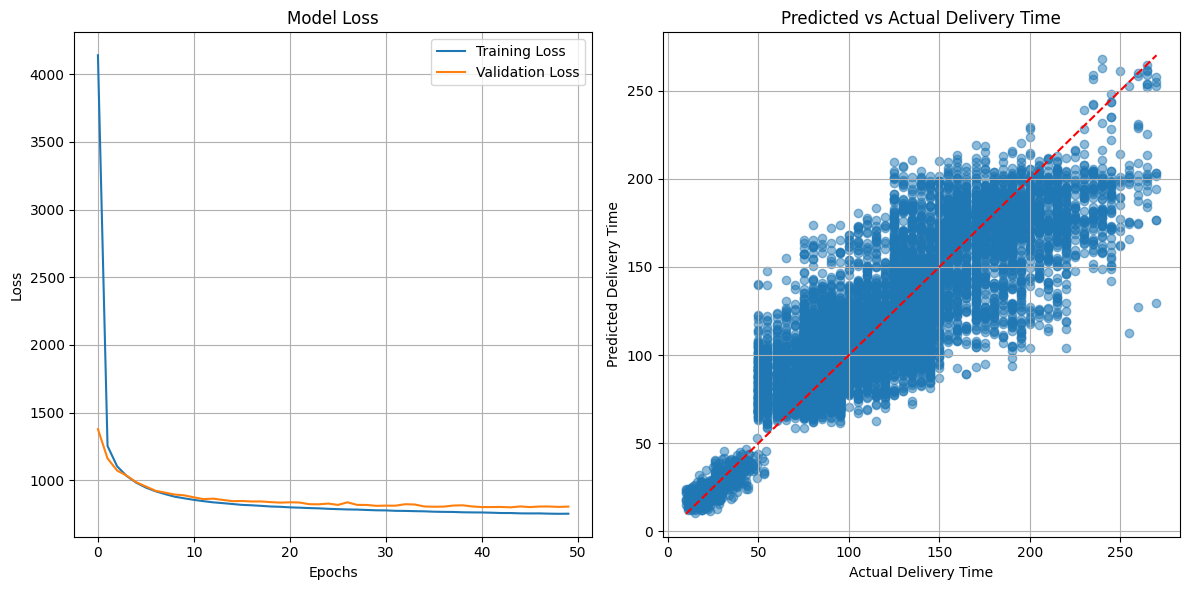

In [29]:

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Delivery Time')
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')
plt.grid()

plt.tight_layout()
plt.show()


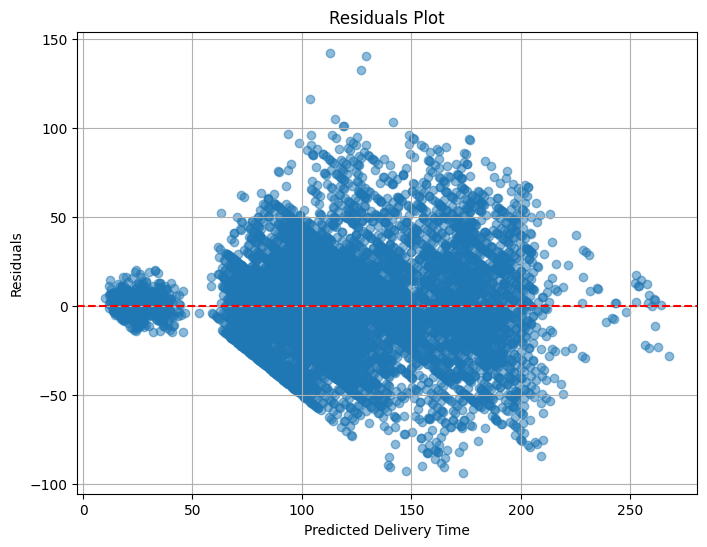

In [31]:
residuals = y_test - predictions.ravel()

plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Predicted Delivery Time')
plt.ylabel('Residuals')
plt.grid()
plt.show()
